# Convert Class Vectors to Binary Class Matrices
Convert the class vectors to binary class matrices using the `to_categorical` function from Keras. This is necessary for categorical cross-entropy loss.

In [1]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob
import shutil
import zipfile
import os

Aquí sería donde descomprimo el dataset, pero como estoy usando jupyter, debo borrar la carpeta (si existe) y volver a descomprimirla. Luego veremos por qué es necesario borrar la carpeta cada vez que ejecutemos el cuaderno

In [2]:
def eliminar_carpetas(carpeta):
    if os.path.exists(carpeta):
        shutil.rmtree(carpeta)
        print(f"Carpeta '{carpeta}' eliminada.")
    else:
        print(f"La carpeta '{carpeta}' no existe.")

def extraer_zip(archivo_zip, destino):
    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        zip_ref.extractall(destino)
        print(f"Archivo '{archivo_zip}' extraído en '{destino}'.")

# Ejemplo de uso
carpeta_a_eliminar = 'ruta/a/tu/carpeta'
archivo_zip = 'ruta/a/tu/archivo.zip'
destino_extraccion = 'ruta/a/tu/destino'

eliminar_carpetas("Chessman-image-dataset")
extraer_zip("archive.zip", ".")


Carpeta 'Chessman-image-dataset' eliminada.
Archivo 'archive.zip' extraído en '.'.


In [3]:
#Hacemos una relación entre los nombres de las imágenes y las clases
MAP_CHARACTERS = { 0: 'Bishop', 1: 'King', 2: 'Knight', 3: 'Pawn', 4: 'Queen', 5: 'Rook' }
# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 150

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
	"""Esta función carga los datos de training en imágenes.

	Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
	para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

	Args:
		dirname: directorio completo del que leer los datos
		map_characters: variable de mapeo entre labels y personajes
		verbose: si es True, muestra información de las imágenes cargadas

	Returns:
		X, y: X es un array con todas las imágenes cargadas con tamaño
	IMG SIZE x IMG SIZE
				y es un array con las labels de correspondientes a cada imagen
	"""
	X_train = []
	y_train = []
	for label, character in map_characters.items():        
		files = os.listdir(os.path.join(dirname, character))
		images = [file for file in files if file.endswith("jpg")]
		if verbose:
			print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
		for image_name in images:
			image = cv2.imread(os.path.join(dirname, character, image_name))
			X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
			y_train.append(label)
	return np.array(X_train), np.array(y_train)


def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    
    # Usa el patrón ** para incluir subcarpetas y recursive=True
    folder = glob.glob(dirname + '/**/*.*', recursive=True)
    
    for filename in folder:
        char_name = filename.split('\\')[-2]
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    
    return np.array(X_test), np.array(y_test)


In [5]:
import shutil
from sklearn.model_selection import train_test_split


def split_dataset(source_dir, dest_dir, split_ratio=0.3):
	"""
	Esta función divide el dataset en dos partes, una para training y otra para test, y lo pone en directorios distintos.
	"""
	if not os.path.exists(dest_dir):
		os.makedirs(dest_dir)
	
	for character in os.listdir(source_dir):
		character_path = os.path.join(source_dir, character)
		if os.path.isdir(character_path):
			images = [file for file in os.listdir(character_path) if file.endswith("jpg")]
			train_images, test_images = train_test_split(images, test_size=split_ratio, random_state=42)
			
			character_dest_path = os.path.join(dest_dir, character)
			if not os.path.exists(character_dest_path):
				os.makedirs(character_dest_path)
			
			for image in test_images:
				shutil.move(os.path.join(character_path, image), os.path.join(character_dest_path, image))

source_directory = ".\\Chessman-image-dataset\\Chess"
# destination_directory = ".\\Chessman-image-dataset\\Chess_test"
# split_dataset(source_directory, destination_directory)

In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = ".\\Chessman-image-dataset\\Chess"
# DATASET_TEST_PATH_COLAB = "Chessman-image-dataset\\Chess_test"
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
# X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)
X = X / 255.0
# X_t = X_t / 255.0
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

Leyendo 71 imágenes encontradas de Bishop
Leyendo 60 imágenes encontradas de King
Leyendo 93 imágenes encontradas de Knight
Leyendo 87 imágenes encontradas de Pawn
Leyendo 67 imágenes encontradas de Queen
Leyendo 87 imágenes encontradas de Rook


In [7]:
### Convert Class Vectors to Binary Class Matrices

En esta sección, convertiremos los vectores de clase en matrices de clase binaria utilizando la función `to_categorical` de Keras. Esto es necesario para la pérdida de entropía cruzada categórica.

# Define Convolutional Layer
Define a convolutional layer with specified filters and kernel size. This layer will be used in the model.

In [8]:
filters = 32  # Valor de ejemplo para filtros
kernel_size = (3, 3)  # Valor de ejemplo para el tamaño del kernel

conv_layer = keras.layers.Conv2D(
    filters, 
    kernel_size, 
    strides=(1, 1), 
    padding='valid', 
    data_format=None, 
    dilation_rate=(1, 1), 
    activation=None, 
    use_bias=True, 
    kernel_initializer='glorot_uniform', 
    bias_initializer='zeros', 
    kernel_regularizer=None, 
    bias_regularizer=None, 
    activity_regularizer=None, 
    kernel_constraint=None, 
    bias_constraint=None    
)

# Build and Compile the Model
Build a sequential model with multiple convolutional layers, a flatten layer, dense layers, and a dropout layer. Compile the model using the Adam optimizer and categorical cross-entropy loss.

In [9]:
from keras.regularizers import l2

# Construcción del modelo secuencial
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.01)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

# Resumen del modelo
model.summary()

# Compilación del modelo
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Javier\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 144, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2654208)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   679,477,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 679,572,294 (2.53 GB)

 Trainable params: 679,572,294 (2.53 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from sklearn.model_selection import train_test_split

# Separamos los datos en training y validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (372, 150, 150, 3)
Validation data shape: (93, 150, 150, 3)


Número de elementos en X:  465


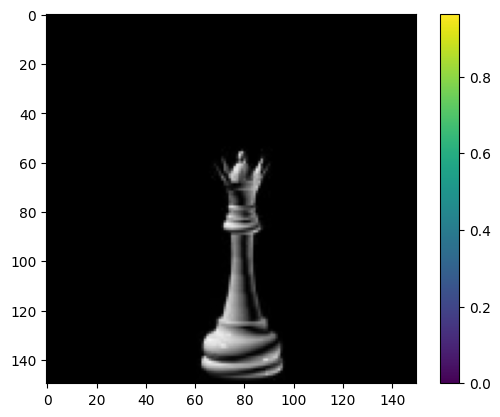

Queen
(150, 150, 3)


In [11]:
 #Declaramos una función para visualizar las imágenes
def visualize_example(x):
	plt.figure()
	plt.imshow(x)
	plt.colorbar()
	plt.grid(False)
	plt.show()
print("Número de elementos en X: ",len(X))
# for i in range(len(X)):
# 	visualize_example(X[i])
# 	print(MAP_CHARACTERS[y[i]])
 
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [12]:
#batch_size=128
num_classes=6
epochs=15
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
# y_t=keras.utils.to_categorical(y_t,num_classes)

X.shape

(465, 150, 150, 3)

# Train the Model
Train the model using the training data and validate it using the validation data. The training process will run for a specified number of epochs.

In [13]:
from keras.utils import to_categorical

# Aseguramos que y_train y y_val estén codificados en one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - accuracy: 0.1760 - loss: 92.8450 - val_accuracy: 0.1613 - val_loss: 29.6399
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.2064 - loss: 29.2325 - val_accuracy: 0.2043 - val_loss: 24.9972
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.2628 - loss: 23.0525 - val_accuracy: 0.1613 - val_loss: 17.5816
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.3493 - loss: 16.0133 - val_accuracy: 0.2366 - val_loss: 12.1245
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.4433 - loss: 11.0320 - val_accuracy: 0.2473 - val_loss: 9.2305
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.5476 - loss: 8.1106 - val_accuracy: 0.2688 - val_loss: 7.8692
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.6891 - loss: 6.6220 - val_accuracy: 0.2258 - val_loss: 6.8924
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.6767 - loss: 5.9843 - val_accuracy: 0.2366 -

# Plot Training History
Plot the training history to visualize the accuracy and loss over the epochs for both training and validation data.

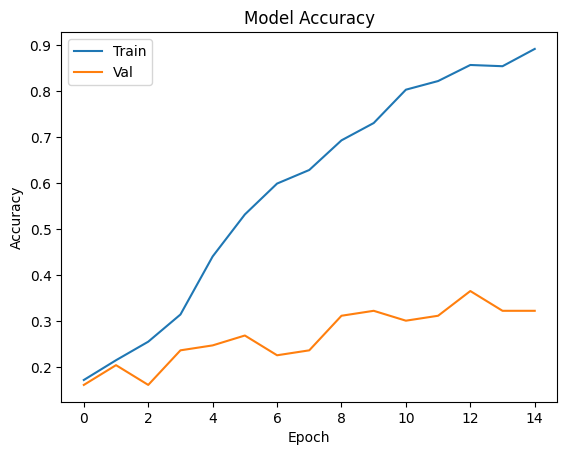

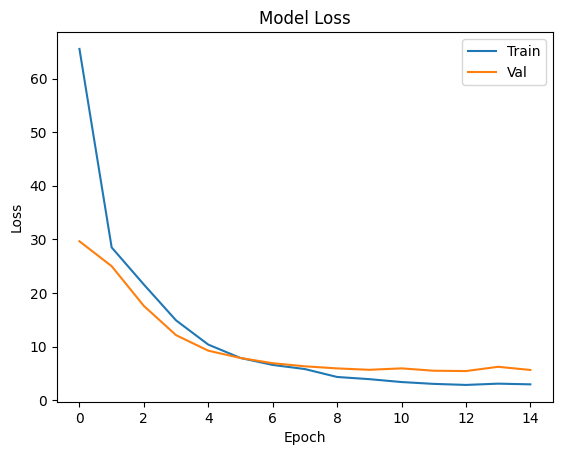

In [14]:
# Función para graficar la precisión del modelo
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# Función para graficar la pérdida del modelo
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# Graficar la precisión y la pérdida del modelo
plot_acc(history)
plot_loss(history)